<a href="https://colab.research.google.com/github/thiennhoangg1/ChatGPT-Prompt-Automation/blob/main/RDS_Lab10_students_MIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔐 Privacy Lab — Understanding Membership Inference Attacks (MIA)

**Goal of this lab**  
This lab guides you step-by-step through the core concept of **Membership Inference Attacks (MIA)** — a powerful privacy attack that tests whether a machine learning model unintentionally leaks information about its training data.  
You will *play both roles*: the **model owner (victim)** who trains a classifier, and the **attacker** who tries to determine whether a given sample was part of the model’s training set.

---

### What is a Membership Inference Attack?
In a **Membership Inference Attack**, an adversary queries a trained model and observes its **outputs (predictions or confidences)** to guess if a data point was part of the model’s **training set**.  
Well-generalized models treat new and old samples similarly, but **overfitted models** often behave differently on training data — this difference becomes the leakage exploited by MIA.

---

### What you will do in this lab
By the end of this notebook, you will:
1. **Prepare and split data** into *Target* and *Shadow* subsets (simulating the victim and the attacker’s world).  
2. **Train two models** — one Target model (victim) and one Shadow model (attacker’s replica).  
3. **Extract model behavior** (predictions, losses, and accuracies) for both member and non-member samples.  
4. **Train an Attack Model** that learns to distinguish members from non-members based only on model outputs.  
5. **Evaluate privacy leakage** using accuracy, precision, recall, and F1-score of the attack.  

---

### Learning outcomes
After completing this lab, you will be able to:
- Explain how **overfitting leads to privacy risks**.  
- Understand the difference between **Target**, **Shadow**, and **Attack** models.  
- Implement a **black-box MIA** using the **Adversarial Robustness Toolbox (ART)**.  
- Quantitatively measure **how much a model leaks information** about its training data.

---

###  Structure of the notebook
1. **Setup:** Mount Google Drive and prepare directories (`ML_Privacy_Lab/`).  
2. **Dataset Preparation:** Load and split CIFAR-10 into four subsets  
   *(target_train, target_test, shadow_train, shadow_test)*.  
3. **Model Training:** Train and save both Target and Shadow models.  
4. **Attack Execution:** Use ART’s `MembershipInferenceBlackBox` to train the attack model.  
5. **Analysis:** Visualize attack performance and discuss mitigation strategies.  

---

**By the end of this lab**, you will understand not only how to perform a Membership Inference Attack, but also *why* it works — and what this means for the privacy of machine learning models.


## **Dataset Preparation: CIFAR10** ##


In [1]:
#!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu126
!pip install adversarial-robustness-toolbox
#!pip install matplotlib
#!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.8 MB/s eta 0:00:00


In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import json

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
# ==============================================
#   PRIVACY LAB SETUP — DATA + MODEL LOADER
#   This script automatically:
#     • mounts Google Drive (for persistent storage)
#     • downloads datasets (CIFAR-10)
#     • builds the directory structure
#     • splits data for target/shadow models
# ==============================================

import os
import time
import torch
import torchvision
from torchvision import transforms, models

# ======================================
# 1- Mount Google Drive for persistence
# ======================================
# In Google Colab, this lets us store data permanently in Drive.
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_DIR = '/content/drive/MyDrive/ML_Privacy_Lab'
except ModuleNotFoundError:
    # If not running on Colab (e.g., locally), fallback to a local directory.
    BASE_DIR = './ML_Privacy_Lab'

# Automatically create a folder structure inside Drive
DATA_ROOT = os.path.join(BASE_DIR, 'data')
os.makedirs(DATA_ROOT, exist_ok=True)
print(f" Using data directory: {DATA_ROOT}")

# ======================================
# 2️ - Helper Function — Check Dataset
# ======================================
def _dataset_present(dataset_name: str, root: str) -> bool:
    """
    PURPOSE:
      Checks whether the dataset has already been downloaded.
      This prevents wasting time and bandwidth by downloading the same files twice.

    INPUTS:
      dataset_name : name of the dataset ('cifar10' or 'stl10')
      root         : directory where data is stored

    RETURNS:
      True if dataset already exists locally, False otherwise.
    """
    dataset_name = dataset_name.lower()
    if dataset_name == "cifar10":
        return os.path.exists(os.path.join(root, "cifar-10-batches-py"))
    elif dataset_name == "stl10":
        return os.path.exists(os.path.join(root, "stl10_binary"))
    return False

# ======================================
# 3️ - Helper Function — Download Dataset
# ======================================
def _download_dataset_first(dataset_name: str, root: str) -> float:
    """
    PURPOSE:
      Downloads the chosen dataset (CIFAR-10) into the given folder.
      Measures and reports the total download + extraction time.
    INPUTS:
      dataset_name : 'cifar10'
      root         : local directory where data will be stored

    RETURNS:
      Total time in seconds required to download the dataset.
    """
    dataset_name = dataset_name.lower()
    os.makedirs(root, exist_ok=True)

    # If dataset already exists, skip download.
    if _dataset_present(dataset_name, root):
        print(f"[download] {dataset_name.upper()} already present under: {root}")
        return 0.0

    print(f"[download] Fetching {dataset_name.upper()} to: {root} ...")
    t0 = time.perf_counter()

    # torchvision handles official dataset fetching and extraction automatically.
    if dataset_name == "cifar10":
        torchvision.datasets.CIFAR10(root=root, train=True, download=True)
        torchvision.datasets.CIFAR10(root=root, train=False, download=True)
    elif dataset_name == "stl10":
        torchvision.datasets.STL10(root=root, split="train", download=True)
        torchvision.datasets.STL10(root=root, split="test", download=True)
    else:
        raise ValueError(f"Dataset {dataset_name} not supported in this lab version.")

    dt = time.perf_counter() - t0
    print(f"[download]  Completed in {dt:.3f} seconds.")
    return dt
# ======================================
# 4️ - Core Function — Get Model + Dataset
# ======================================
def get_model_dataset(dataset_name='cifar10', attr=None, root=DATA_ROOT, model_type='resnet18'):
    """
    PURPOSE:
      Prepares the dataset and models used for *privacy testing*.
      This includes:
        - Downloading the dataset (timed)
        - Defining basic image preprocessing transforms
        - Loading training/testing splits
        - Initializing two neural network models:
            1. Target model (to be attacked)
            2. Shadow model (used to simulate attacker’s knowledge)

    WHY IMPORTANT IN PRIVACY LAB:
      In Membership Inference Attacks (MIA), we need two identical architectures:
      one to represent the “victim” and one for the “attacker’s surrogate”.
      This setup function prepares both.

    RETURNS:
      num_classes : number of output classes (e.g., 10)
      dataset     : concatenated train+test dataset
      target_model, shadow_model : two model instances
    """
    dataset_name = dataset_name.lower()
    download_time_s = _download_dataset_first(dataset_name, root)

    # Configure dataset-specific preprocessing
    if dataset_name == "cifar10":
        num_classes = [10]
        transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010)),
        ])
        train_set = torchvision.datasets.CIFAR10(root=root, train=True, transform=transform, download=False)
        test_set = torchvision.datasets.CIFAR10(root=root, train=False, transform=transform, download=False)
        dataset = torch.utils.data.ConcatDataset([train_set, test_set])
        input_channel = 3

    elif dataset_name == "stl10":
        num_classes = [10]
        transform = transforms.Compose([
            transforms.Resize((96, 96)),
            transforms.ToTensor(),
        ])
        train_set = torchvision.datasets.STL10(root=root, split='train', transform=transform, download=False)
        test_set = torchvision.datasets.STL10(root=root, split='test', transform=transform, download=False)
        dataset = torch.utils.data.ConcatDataset([train_set, test_set])
        input_channel = 3

    else:
        raise ValueError(f"Dataset {dataset_name} not supported in this lab version.")

    # Build two identical models for privacy evaluation
    if model_type.lower() == 'resnet18':
        target_model = models.resnet18(num_classes=num_classes[0])
        shadow_model = models.resnet18(num_classes=num_classes[0])
        if input_channel == 1:
            target_model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
            shadow_model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    else:
        raise ValueError(f"Model type {model_type} not supported.")

    print(f" Download time: {download_time_s:.3f} s")
    print(f" Loaded {dataset_name.upper()} — total {len(dataset)} samples")
    print(f" Model: {model_type.upper()} | Channels: {input_channel} | Classes: {num_classes[0]}")

    return num_classes, dataset, target_model, shadow_model
# ======================================
# 5️ - Split Function — Target/Shadow sets
# ======================================
def prepare_dataset(dataset='cifar10', attr=None, root=DATA_ROOT, model_type='resnet18'):
    """
    PURPOSE:
      Splits the dataset into 4 equal parts to simulate two independent
      training/testing environments:
        • Target Train — used to train the victim model
        • Target Test  — used to test the victim model
        • Shadow Train — used by the attacker to train a surrogate model
        • Shadow Test  — used to test the attacker’s model

    WHY IMPORTANT IN PRIVACY LAB:
      This mirrors the real-world setting of a membership inference attack,
      where the attacker has a similar (but not identical) dataset.

    RETURNS:
      num_classes, target_train, target_test, shadow_train, shadow_test, target_model, shadow_model
    """
    num_classes, dataset, target_model, shadow_model = get_model_dataset(
        dataset, attr=attr, root=root, model_type=model_type
    )

    print("Number of classes in target model:", num_classes)
    length = len(dataset)
    each_length = length // 4

    # Fix seed for reproducibility
    torch.manual_seed(seed)

    target_train, target_test, shadow_train, shadow_test, _ = torch.utils.data.random_split(
        dataset,
        [each_length, each_length, each_length, each_length, length - (each_length * 4)]
    )

    print(f" Split completed:")
    print(f"  Target Train: {len(target_train)}")
    print(f"  Target Test:  {len(target_test)}")
    print(f"  Shadow Train: {len(shadow_train)}")
    print(f"  Shadow Test:  {len(shadow_test)}")

    return num_classes, target_train, target_test, shadow_train, shadow_test, target_model, shadow_model


Mounted at /content/drive
 Using data directory: /content/drive/MyDrive/ML_Privacy_Lab/data


In [5]:
num_classes, target_train, target_test, shadow_train, shadow_test, target_model, shadow_model = prepare_dataset(
    dataset='cifar10',
    model_type='resnet18'
)


[download] Fetching CIFAR10 to: /content/drive/MyDrive/ML_Privacy_Lab/data ...


100%|██████████| 170M/170M [00:03<00:00, 43.6MB/s]


[download]  Completed in 9.651 seconds.
 Download time: 9.651 s
 Loaded CIFAR10 — total 60000 samples
 Model: RESNET18 | Channels: 3 | Classes: 10
Number of classes in target model: [10]
 Split completed:
  Target Train: 15000
  Target Test:  15000
  Shadow Train: 15000
  Shadow Test:  15000


##Save the target and shadow dataset.

In [6]:
import os
import torch
import pickle

try:
    Data_PATH = os.path.join(BASE_DIR, "data_saved_sets")
except NameError:
    Data_PATH = "./data_saved_sets"

os.makedirs(Data_PATH, exist_ok=True)
print(f"Saving datasets to: {Data_PATH}")

#Save the dataset splits using torch.save
torch.save(target_train, os.path.join(Data_PATH, 'target_trainset.ph'))
torch.save(target_test,  os.path.join(Data_PATH, 'target_test.ph'))
torch.save(shadow_train, os.path.join(Data_PATH, 'shadow_trainset.ph'))
torch.save(shadow_test,  os.path.join(Data_PATH, 'shadow_test.ph'))

#Save num_classes using pickle
with open(os.path.join(Data_PATH, 'num_classes.ph'), "wb") as fp:
    pickle.dump(num_classes, fp)

print(" Saved: target_trainset.ph, target_test.ph, shadow_trainset.ph, shadow_test.ph, num_classes.ph")


Saving datasets to: /content/drive/MyDrive/ML_Privacy_Lab/data_saved_sets
 Saved: target_trainset.ph, target_test.ph, shadow_trainset.ph, shadow_test.ph, num_classes.ph


## **Exploratory Analysis for CIFAR10** ##


Load the saved datasets

In [7]:
#Loading the saved objects
import torch
import pickle
from pathlib import Path
import torch, torchvision as tv

Data_PATH = Path(Data_PATH)

target_train = torch.load(Data_PATH / 'target_trainset.ph', weights_only=False)
target_test  = torch.load(Data_PATH / 'target_test.ph',weights_only=False)
shadow_train = torch.load(Data_PATH / 'shadow_trainset.ph',weights_only=False)
shadow_test  = torch.load(Data_PATH / 'shadow_test.ph', weights_only=False)

with open(Data_PATH / 'num_classes.ph', 'rb') as fp:
    num_classes_loaded = pickle.load(fp)


**Visualize Sample Images from Target Train Set**


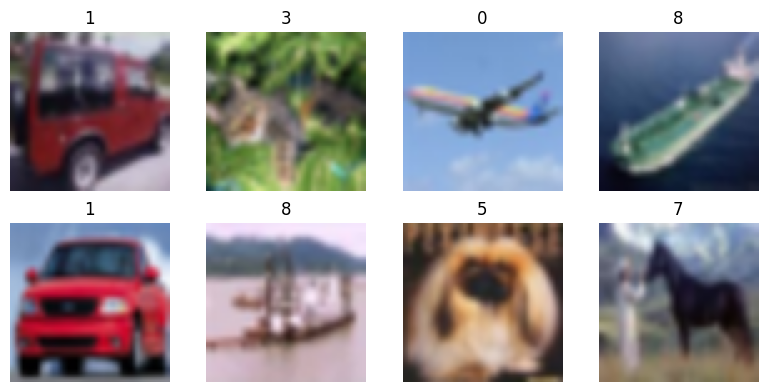

In [8]:
## skip this one if you want

def imshow(img):
    img = img * torch.tensor([0.2023,0.1994,0.2010]).view(3,1,1) + torch.tensor([0.4914,0.4822,0.4465]).view(3,1,1)
    img = img.clamp(0,1)
    npimg = img.permute(1, 2, 0).numpy()
    plt.imshow(npimg)
    plt.axis('off')

fig = plt.figure(figsize=(8, 4))
for i in range(8):
    ax = fig.add_subplot(2, 4, i+1)
    img, label = target_train[random.randint(0, len(target_train)-1)]
    imshow(img)
    ax.set_title(str(label))
    ax.axis('off')
plt.tight_layout()
plt.show()

**1. Class Distribution**
Check if the dataset is balanced across all classes.

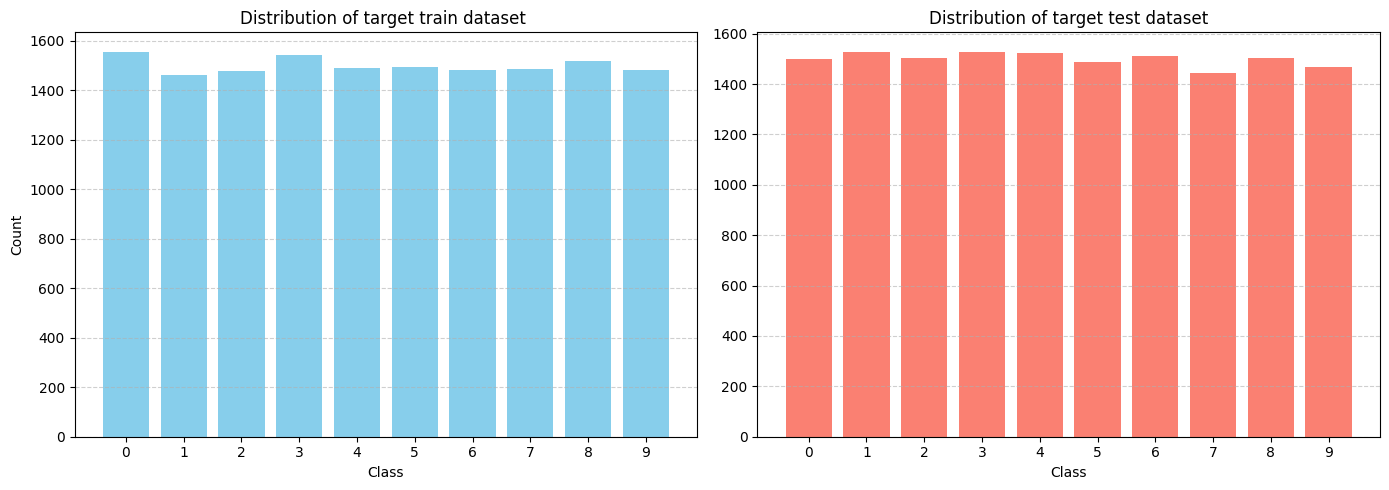

In [9]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution_row(train_dataset, test_dataset):
    """
    Plots two separate bar charts (train + test) in the same row.
    """

    # ---- Extract labels ----
    train_labels = [label for _, label in train_dataset]
    test_labels  = [label for _, label in test_dataset]

    train_counts = Counter(train_labels)
    test_counts  = Counter(test_labels)

    classes = sorted(list(set(train_counts.keys()) | set(test_counts.keys())))

    train_values = [train_counts[c] for c in classes]
    test_values  = [test_counts[c] for c in classes]

    # ---- Create 1 row, 2 columns ----
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Left: TRAIN dataset
    axs[0].bar(classes, train_values, color='skyblue')
    axs[0].set_title("Distribution of target train dataset ")
    axs[0].set_xlabel("Class")
    axs[0].set_ylabel("Count")
    axs[0].set_xticks(classes)
    axs[0].grid(axis='y', linestyle='--', alpha=0.6)

    #Right: TEST dataset
    axs[1].bar(classes, test_values, color='salmon')
    axs[1].set_title("Distribution of target test dataset")
    axs[1].set_xlabel("Class")
    axs[1].set_xticks(classes)
    axs[1].grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()


plot_class_distribution_row(target_train, target_test)


**3. Class-wise Sample Images**
Images from each class to see intra-class variation.

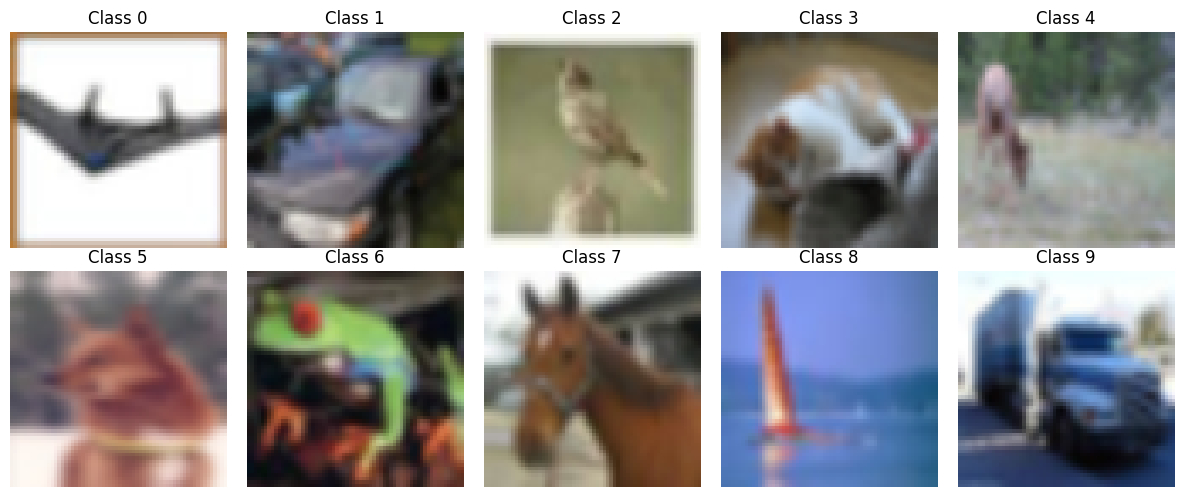

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for cls in range(10):
    # Find first image of this class
    for img, label in target_train:
        if label == cls:
            ax = axes[cls//5, cls%5]
            img_for_show = img * torch.tensor([0.2023,0.1994,0.2010]).view(3,1,1) + torch.tensor([0.4914,0.4822,0.4465]).view(3,1,1)
            img_for_show = img_for_show.clamp(0,1)
            ax.imshow(img_for_show.permute(1,2,0).numpy())
            ax.set_title(f"Class {cls}")
            ax.axis('off')
            break
plt.tight_layout()
plt.show()


---

##  Phase 1 — Defender’s World (Target Model) ##
 **Goal:** The defender wants to train a useful model while protecting which data samples were used.

                   ┌──────────────────────────────┐
                   │        Target Model          │
                   │   (Victim / Private Model)   │
                   └─────────────┬────────────────┘
                                 │
               ┌─────────────────┴─────────────────┐
               │                                   │
               ▼                                   ▼
     ┌──────────────────────┐           ┌──────────────────────┐
     │  Target Train        │           │  Target Test         │
     │  (members)           │           │  (non-members)       │
     └──────────────────────┘           └──────────────────────┘
      Used to train victim model         Used to test generalization
      Represents private data            Represents unseen/public data






## Train the Target Model (ResNet18 on CIFAR-10) ##

In this section, you’ll train the **target model** — the one that the membership inference attack will later try to attack.

- Dataset: CIFAR-10
- Model: ResNet-18
- Loss: Cross-Entropy
- Optimizer: Adam
- Goal: Achieve a reasonable accuracy while maintaining some overfitting so that the attack has signal.

In [10]:
#Imports and setup
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt

MODEL_DIR = os.path.join(BASE_DIR, "saved_models")
os.makedirs(MODEL_DIR, exist_ok=True)
print(f" Models will be saved in: {MODEL_DIR}")

 Models will be saved in: /content/drive/MyDrive/ML_Privacy_Lab/saved_models


###  Model Training Framework

This class defines a **training pipeline** for our deep learning models (Target or Shadow).  
It handles all the main components needed for training and evaluation:

- **Initialization (`__init__`)**:  
  Sets up the model, loss function (`CrossEntropyLoss`), optimizer (SGD), and learning rate scheduler.

- **`train()`**:  
  Runs one full training epoch, performing forward/backward passes and weight updates.  
  Returns both **training accuracy** and **training loss**.

- **`test()`**:  
  Evaluates model performance on unseen test data, returning **test accuracy** and **test loss**.

- **`saveModel()`**:  
  Saves the trained model’s weights for later use (e.g., during attack evaluation).

The helper function **`train_model()`** wraps this process, training the model for multiple epochs while tracking and printing:
- Training vs. Test Accuracy  
- Training vs. Test Loss  
- Overfitting Rate (how much better the model performs on training data)

This structure makes it easy to reuse the same training loop for both the **Target** and **Shadow** models in the Membership Inference Attack workflow.


In [11]:
class model_training():
    def __init__(self, trainloader, testloader, model, device):
        self.device = device
        self.net = model.to(self.device)
        self.trainloader = trainloader
        self.testloader = testloader

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.net.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4)
        self.scheduler = lr_scheduler.MultiStepLR(self.optimizer, [50, 75], 0.1)

    def train(self):
        """Train the model for one epoch and return accuracy and loss."""
        self.net.train()
        running_loss, correct, total = 0.0, 0, 0

        for batch_idx, (inputs, targets) in enumerate(self.trainloader):
            if isinstance(targets, list):
                targets = targets[0]
            inputs, targets = inputs.to(self.device), targets.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.net(inputs)
            loss = self.criterion(outputs, targets)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        self.scheduler.step()
        train_acc = correct / total
        train_loss = running_loss / len(self.trainloader)
        return train_acc, train_loss, self.net

    def test(self):
        """Evaluate on the test set."""
        self.net.eval()
        running_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, targets in self.testloader:
                if isinstance(targets, list):
                    targets = targets[0]
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.net(inputs)
                loss = self.criterion(outputs, targets)
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        test_acc = correct / total
        test_loss = running_loss / len(self.testloader)
        return test_acc, test_loss

    def saveModel(self, path):
        torch.save(self.net.state_dict(), path)


def train_model(device, train_set, test_set, model, epochs=50):
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
    test_loader  = torch.utils.data.DataLoader(test_set,  batch_size=64, shuffle=True, num_workers=2)

    trainer = model_training(train_loader, test_loader, model, device)
    # Track metrics
    train_acc_history, test_acc_history = [], []
    train_loss_history, test_loss_history = [], []

    for i in range(epochs):
        print(f"\n<======================= Epoch {i+1}/{epochs} =======================>")
        train_acc, train_loss, target_model = trainer.train()
        test_acc, test_loss = trainer.test()

        print(f"Train Acc: {train_acc*100:.2f}% | Test Acc: {test_acc*100:.2f}%")
        print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
        print(f"Overfitting Rate: {(train_acc - test_acc):.6f}")

        train_acc_history.append(train_acc)
        test_acc_history.append(test_acc)
        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)

    # Save final model in BASE_DIR/saved_models
    FILE_PATH = os.path.join(MODEL_DIR, "target_model.pth")
    trainer.saveModel(FILE_PATH)
    print(f"\n Target model saved to: {FILE_PATH}\n")

    return train_acc_history, test_acc_history, train_loss_history, test_loss_history, target_model


### Target Model Training Routine

The `run_TargetTraining()` function manages the **complete training process** of the **Target Model** — the model that will later be attacked during the Membership Inference phase.

**Key steps:**
1. **Device setup:**  
   Automatically selects GPU (`cuda`) if available, otherwise falls back to CPU.

2. **Training execution:**  
   Calls the `train_model()` function, which performs multi-epoch training while tracking accuracy and loss on both training and test sets.

3. **Performance summary:**  
   After training, it prints the final accuracy and loss values to provide a quick overview of model performance and potential overfitting.

**Output:**  
- Training accuracy & loss history  
- Test accuracy & loss history  
- The fully trained Target Model (ready to be saved or used for attack evaluation)

This function serves as the **entry point** for training the model that represents the *victim* in a Membership Inference Attack scenario.


In [12]:
def run_TargetTraining(target_train, target_test, target_model, device=None, epochs=50):
    """
    Runs full target model training and returns accuracy/loss histories.
    """
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    train_acc, test_acc, train_loss, test_loss, trained_model = train_model(
        device=device,
        train_set=target_train,
        test_set=target_test,
        model=target_model,
        epochs=epochs
    )

    print("\n Training Summary")
    print(f"Final Train Accuracy: {train_acc[-1]*100:.2f}%")
    print(f"Final Test Accuracy : {test_acc[-1]*100:.2f}%")
    print(f"Final Train Loss    : {train_loss[-1]:.4f}")
    print(f"Final Test Loss     : {test_loss[-1]:.4f}")

    return train_acc, test_acc, train_loss, test_loss, trained_model


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import time

t0 = time.perf_counter()

(train_acc_history, test_acc_history,
 train_loss_history, test_loss_history,
 target_model_trained) = run_TargetTraining(
    target_train=target_train,
    target_test=target_test,
    target_model=target_model,
    device=device,
    epochs=50
)

t1 = time.perf_counter()

total_sec = t1 - t0
secs_per_epoch = total_sec / len(train_acc_history)
print(f"\n Training finished in {total_sec:.2f} sec "
      f"(~{secs_per_epoch:.2f} sec/epoch for {len(train_acc_history)} epochs).")



<======================= Epoch 1/50 =======================>
Train Acc: 37.51% | Test Acc: 45.77%
Train Loss: 1.7316 | Test Loss: 1.5128
Overfitting Rate: -0.082667

<======================= Epoch 2/50 =======================>
Train Acc: 54.17% | Test Acc: 54.31%
Train Loss: 1.2921 | Test Loss: 1.2991
Overfitting Rate: -0.001400

<======================= Epoch 3/50 =======================>
Train Acc: 63.84% | Test Acc: 55.91%
Train Loss: 1.0257 | Test Loss: 1.3129
Overfitting Rate: 0.079267

<======================= Epoch 4/50 =======================>
Train Acc: 72.15% | Test Acc: 58.15%
Train Loss: 0.7979 | Test Loss: 1.2584
Overfitting Rate: 0.140000

<======================= Epoch 5/50 =======================>
Train Acc: 78.79% | Test Acc: 61.81%
Train Loss: 0.6153 | Test Loss: 1.2405
Overfitting Rate: 0.169867

<======================= Epoch 6/50 =======================>
Train Acc: 84.87% | Test Acc: 58.49%
Train Loss: 0.4287 | Test Loss: 1.5078
Overfitting Rate: 0.263733

<======

**Training Progress — Target Model (plots)**

The below cell plots the training history collected during model training:

- **Left (Accuracy):** shows training vs test accuracy per epoch.  
  - A large gap (train ≫ test) indicates overfitting and higher privacy risk.
- **Right (Loss):** shows training vs test loss per epoch.  
  - Converging curves indicate stable learning; diverging curves indicate overfitting or poor generalization.

**Notes**
- Use this plot to decide whether to rerun training with stronger regularization (dropout, weight decay) or fewer epochs before running the attack.  


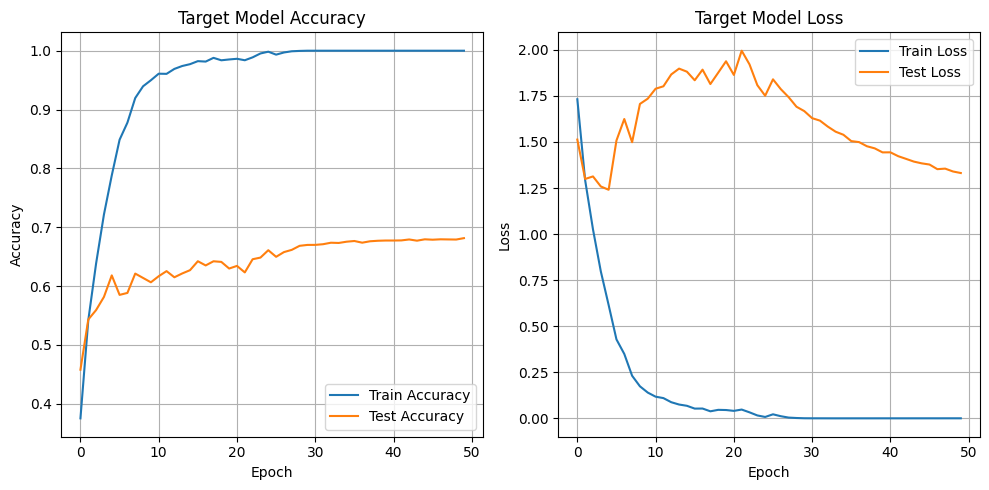

In [14]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(train_acc_history, label="Train Accuracy")
plt.plot(test_acc_history, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Target Model Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_loss_history, label="Train Loss")
plt.plot(test_loss_history, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Target Model Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



**Shadow Train Accuracy** rapidly approaches 100% and the loss approaches zero, indicating the model can easily memorize the shadow training data.

**Shadow Test Accuracy** has a much lower value (~60–65%), and the **test loss stays high** and even increases, showing **the model does not generalize well to new samples** outside the shadow training split.

**Overfitting is clear**: the model is learning specifics of its train set that do not help on the test set.

**MIA Implication**: This memorization makes the shadow model an ideal proxy for training membership inference attacks, since it mimics the overfitting pattern often seen in real-world targets.

**Takeaway**
The close resemblance between the shadow and target models’ generalization behavior is precisely why shadow modeling is so powerful for privacy attacks: the attacker assumes that vulnerabilities (like overfitting) are similar for both models, enabling realistic simulation and attack strategy development.---

##  Phase 2 — Attacker’s World (Shadow Model) ##
 **Goal:** The attacker mimics the victim by training a similar model on their own dataset.

                   ┌──────────────────────────────┐
                   │        Shadow Model          │
                   │  (Attacker’s Replica Model)  │
                   └─────────────┬────────────────┘
                                 │
               ┌─────────────────┴─────────────────┐
               │                                   │
               ▼                                   ▼
     ┌──────────────────────┐           ┌──────────────────────┐
     │     Shadow Train     │           │     Shadow Test      │
     │     (members)        │           │     (non-members)    │
     └──────────────────────┘           └──────────────────────┘
    Used by attacker to train model     Used to observe unseen behavior
    Same distribution as Target         Never overlaps with Target data





##Train Shadow model (same logic as target model)

**1. Training Setup**


In [15]:
def train_shadow_model(device, shadow_train, shadow_test, shadow_model, epochs=50):
    """
    Trains the shadow model using the same logic as the target model training.
    Saves to BASE_DIR/saved_models/shadow_model.pth and returns metric histories.
    """
    # reuse the same training routine & class you already defined for the target model
    train_loader = torch.utils.data.DataLoader(shadow_train, batch_size=64, shuffle=True, num_workers=2)
    test_loader  = torch.utils.data.DataLoader(shadow_test,  batch_size=64, shuffle=True, num_workers=2)

    trainer = model_training(train_loader, test_loader, shadow_model, device)

    shadow_train_acc_history, shadow_test_acc_history = [], []
    shadow_train_loss_history, shadow_test_loss_history = [], []

    for i in range(epochs):
        print(f"\n<======================= Shadow Epoch {i+1}/{epochs} =======================>")
        train_acc, train_loss, shadow_model_trained = trainer.train()
        test_acc, test_loss = trainer.test()

        print(f"Train Acc: {train_acc*100:.2f}% | Test Acc: {test_acc*100:.2f}%")
        print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
        print(f"Overfitting Rate: {(train_acc - test_acc):.6f}")

        shadow_train_acc_history.append(train_acc)
        shadow_test_acc_history.append(test_acc)
        shadow_train_loss_history.append(train_loss)
        shadow_test_loss_history.append(test_loss)

    # save in BASE_DIR/saved_models as 'shadow_model.pth'
    shadow_path = os.path.join(MODEL_DIR, "shadow_model.pth")
    trainer.saveModel(shadow_path)
    print(f"\n Shadow model saved to: {shadow_path}\n")

    return (shadow_train_acc_history, shadow_test_acc_history,
            shadow_train_loss_history, shadow_test_loss_history,
            shadow_model_trained)


We'll use the same ResNet18 configuration. Training will proceed just as with the (real) target model, but on the shadow split.

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import time

t0 = time.perf_counter()

# Train the shadow model
(shadow_train_acc_history, shadow_test_acc_history,
 shadow_train_loss_history, shadow_test_loss_history,
 shadow_model_trained) = train_shadow_model(
    device=device,
    shadow_train=shadow_train,
    shadow_test=shadow_test,
    shadow_model=shadow_model,
    epochs=50
)

t1 = time.perf_counter()

total_sec = t1 - t0
secs_per_epoch = total_sec / len(train_acc_history)
print(f"\n Training finished in {total_sec:.2f} sec "
      f"(~{secs_per_epoch:.2f} sec/epoch for {len(train_acc_history)} epochs).")


<======================= Shadow Epoch 1/50 =======================>
Train Acc: 38.68% | Test Acc: 47.20%
Train Loss: 1.7100 | Test Loss: 1.4644
Overfitting Rate: -0.085200

<======================= Shadow Epoch 2/50 =======================>
Train Acc: 53.83% | Test Acc: 51.50%
Train Loss: 1.3031 | Test Loss: 1.4175
Overfitting Rate: 0.023333

<======================= Shadow Epoch 3/50 =======================>
Train Acc: 63.52% | Test Acc: 54.43%
Train Loss: 1.0418 | Test Loss: 1.3467
Overfitting Rate: 0.090933

<======================= Shadow Epoch 4/50 =======================>
Train Acc: 71.03% | Test Acc: 55.33%
Train Loss: 0.8238 | Test Loss: 1.3599
Overfitting Rate: 0.156933

<======================= Shadow Epoch 5/50 =======================>
Train Acc: 77.55% | Test Acc: 59.57%
Train Loss: 0.6291 | Test Loss: 1.2955
Overfitting Rate: 0.179800

<======================= Shadow Epoch 6/50 =======================>
Train Acc: 85.30% | Test Acc: 59.11%
Train Loss: 0.4183 | Test Loss: 1

**Plot Accuracy Curves**
Visual summary: compare training and test accuracy over epochs to observe learning and potential overfitting.

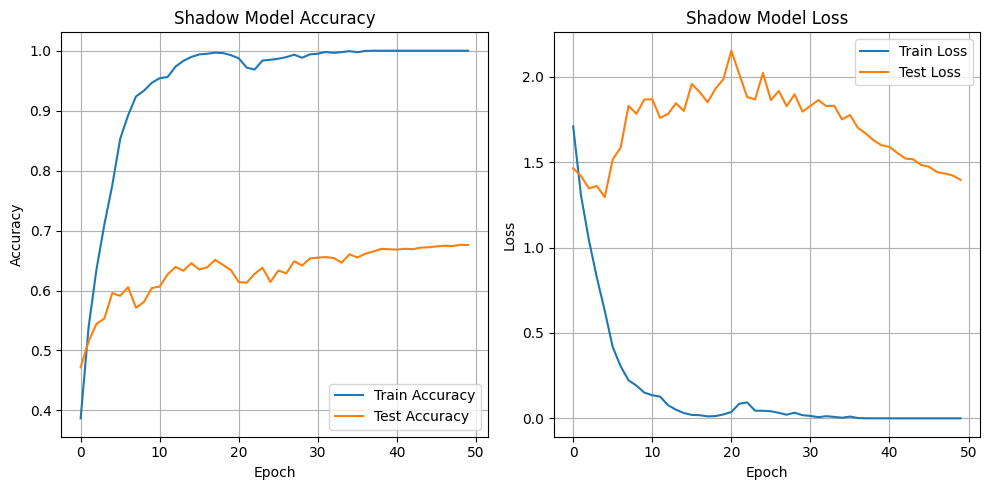

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(shadow_train_acc_history, label="Train Accuracy")
plt.plot(shadow_test_acc_history, label="Test Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Shadow Model Accuracy")
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(shadow_train_loss_history, label="Train Loss")
plt.plot(shadow_test_loss_history, label="Test Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Shadow Model Loss")
plt.legend(); plt.grid(True)

plt.tight_layout(); plt.show()

---

## Phase 3 — Attack Model (Membership Inference)
                   ┌──────────────────────────────┐
                   │        Attack Model          │
                   │    (Binary Classifier)       │
                   └─────────────┬────────────────┘
                                 │
                                 ▼
           ┌──────────────────────────────────────────────┐
           │Learns patterns from Shadow Model outputs     │
           │ to distinguish “member” vs “non-member” data.│
           └──────────────────────────────────────────────┘
                                 │
                                 ▼
                   ┌──────────────────────────────┐
                   │       Target Model           │
                   │   (Victim / Private Model)   │
                   └──────────────────────────────┘
                                 │
                                 ▼
                 🔍 Predicts whether an input was
                     part of the Target's training data

### Utility Functions for Data Extraction and MIA Preparation

This section defines helper functions that prepare and preprocess data for Membership Inference Attacks (MIA):

- **`get_X_y_from_subset(dataset)`**  
  Converts a PyTorch dataset into full tensors of features and labels by iterating in small batches.  
  Helps transform `Subset` objects (like CIFAR10 splits) into `x_subset` and `y_subset`.

- **`get_predictions_and_labels_from_model(model, dataset)`**  
  Runs inference over a dataset to collect predicted labels and true labels.  
  Used to evaluate target model accuracy and prepare data for the attack.

- **`onehot(y, num_classes)`**  
  Converts numeric labels into one-hot encoded vectors required by ART’s attack interface.

**Note:**  
All attacks here use *prediction vectors* (softmax outputs) instead of raw images for efficiency and lower memory use in Colab.

In [18]:
def get_X_y_from_subset(dataset):
    """
    Load all items from `dataset` (e.g., a torch.utils.data.Subset) and return
    concatenated tensors x_subset (inputs) and y_subset (labels).

    """
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=5, num_workers=1)
    X_list, y_list = [], []
    for _, (inputs, targets) in enumerate(dataloader):
        if isinstance(targets, list):
            targets = targets[0]
        try:
            targets = torch.index_select(targets, 1, torch.tensor([0])).flatten()
        except:
            pass
        X_list.append(inputs); y_list.append(targets)
        del inputs, targets
        torch.cuda.empty_cache()
    x_subset = torch.cat(X_list, dim=0)
    y_subset = torch.cat(y_list, dim=0)
    return x_subset, y_subset

def get_predictions_and_labels_from_model(target_model, dataset, device='cpu'):
    """
    Run the target_model on the dataset and return:
      - predicted classes (1-D tensor)
      - true labels       (1-D tensor)

    This is useful for:
    - computing accuracy/metrics,
    - constructing compact label/prediction arrays for downstream attack analysis.
    """
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, num_workers=1)
    target_model = target_model.to(device); target_model.eval()
    y_pred_list, y_target_list = [], []
    with torch.no_grad():
        for _, (inputs, targets) in enumerate(dataloader):
            if isinstance(targets, list):
                targets = targets[0]
            try:
                targets = torch.index_select(targets, 1, torch.tensor([0])).flatten()
            except:
                pass
            inputs = inputs.to(device)
            logits = target_model(inputs).cpu()
            y_pred_list.append(torch.argmax(logits, dim=1))
            y_target_list.append(targets)
            del inputs, targets
            torch.cuda.empty_cache()
    return torch.cat(y_pred_list, dim=0), torch.cat(y_target_list, dim=0)

def onehot(y, num_classes):
    """
    Convert integer labels y (shape [N]) to one-hot matrix shape [N, num_classes].
    - Accepts y as torch.Tensor or numpy array.
    - Expects num_classes to be an integer (if it's a list like [10], convert it first).
    """
    labels = np.zeros([y.shape[0], num_classes])
    for i, label in enumerate(y):
        labels[i][label] = 1
    return labels

from art.attacks.inference.membership_inference import MembershipInferenceBlackBox
from art.estimators.classification import PyTorchClassifier


## Membership Inference Attack — Black-Box
In this cell we train a **membership inference attack model** using a **shadow model**, then reuse it on the **target model**.

**Pipeline:**

1. **Load trained models and data**
   - We load the pretrained **target** and **shadow** models (`resnet18` on CIFAR-10).
   - We also load their train/test splits: `target_train`, `target_test`, `shadow_train`, `shadow_test`.

2. **Build attack training data from the SHADOW model**
   - For each sample in `shadow_train` and `shadow_test`, we run the **shadow model** and collect:
     - **Prediction vectors** (logits) → shape `[N, num_classes]`
     - **True class labels** → integers in `[0, 9]`
   - Conceptually:
     - samples from `shadow_train` = **members**
     - samples from `shadow_test` = **non-members**

3. **Train the attack model (ART – MembershipInferenceBlackBox)**
   - Inputs to the attack model during training (via ART):
     - `x_shadow_train`: prediction vectors from **shadow_train**
     - `y_shadow_train`: true labels for those samples (converted to one-hot)
     - `x_shadow_test`, `y_shadow_test`: the same for **shadow_test**
   - The attack model learns to distinguish **member vs non-member** *based only on prediction vectors and labels*.

4. **Evaluate the attack**
   - First on the **shadow model** (shadow_train vs shadow_test).
   - Then on the **target model** (target_train vs target_test) using the **same attack model**.
   - We report attack accuracy, precision, recall, and F1, and save them to a CSV file.




In [19]:
import os
from pathlib import Path

import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from art.attacks.inference.membership_inference import MembershipInferenceBlackBox
from art.estimators.classification import PyTorchClassifier

# ---------- Helpers ---------- #

def get_prediction_vectors_and_labels(model, dataset, device="cuda", batch_size=64):
    """
    For each (x, y) in dataset, run the model and return:
      - X_pred: prediction vectors (e.g. logits or probabilities), shape [N, num_classes]
      - y_true: integer class labels, shape [N]

    This is what ART expects when input_type='prediction':
      x = prediction vectors
      y = true class labels (one-hot will be constructed).
    """
    model = model.to(device)
    model.eval()

    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=1)

    X_list = []
    y_list = []

    with torch.no_grad():
        for inputs, targets in loader:
            # Clean targets (handle Subset, ConcatDataset quirks)
            if isinstance(targets, list):
                targets = targets[0]
            try:
                targets = torch.index_select(targets, 1, torch.tensor([0])).flatten()
            except Exception:
                pass

            inputs = inputs.to(device)
            logits = model(inputs).cpu()  # [B, num_classes] predictions

            X_list.append(logits)
            y_list.append(targets)

            del inputs, logits, targets
            torch.cuda.empty_cache()

    X_pred = torch.cat(X_list, dim=0)     # [N, num_classes]
    y_true = torch.cat(y_list, dim=0)     # [N]
    return X_pred.numpy(), y_true.numpy()


def onehot(y, num_classes):
    """
    Convert integer labels y (shape [N]) to one-hot matrix [N, num_classes].
    """
    y = np.asarray(y, dtype=int)
    labels = np.zeros((y.shape[0], num_classes), dtype=np.float32)
    for i, label in enumerate(y):
        labels[i, label] = 1.0
    return labels


class VectorPassthroughModel(torch.nn.Module):
    """
    Simple linear layer that accepts prediction vectors directly.
    Used as a 'base model' for ART so that the attack model operates
    in prediction space.
    """
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc = torch.nn.Linear(input_dim, num_classes)

    def forward(self, x):
        # x: [batch, input_dim]
        return self.fc(x)


In [20]:
# ---------- Main pipeline ---------- #

def run_membership_inference_attack(
    args_s=42,
    args_d='cifar10',
    model_type='resnet18',
    attr=[],
    run_name='colab_run',
    root=None,
    args_o=None,
    repeatrun=1
):
    """
    Black-box Membership Inference Attack (shadow-based)

    Logic:

      0. Load target & shadow models + CIFAR-10 splits (already saved earlier).
      1. Re-evaluate target & shadow classification accuracy.
      2. Build SHADOW attack data in prediction space:
           - x_training: shadow_model predictions on shadow_train (members)
           - x_test:     shadow_model predictions on shadow_test (non-members)
           - y_training, y_test: true class labels for those points
         Membership labels are *implicit* from which set a sample comes from.
      3. Train ART MembershipInferenceBlackBox attack on SHADOW.
      4. Evaluate attack on SHADOW train+test (should be > 0.5 if model overfits).
      5. Build TARGET prediction vectors & labels (target_train/target_test).
      6. Reuse the SAME attack model to infer membership on TARGET.
      7. Save shadow + target attack metrics to CSV.

    Returns:
      attack_model : trained ART MembershipInferenceBlackBox instance.
    """
    base = Path(BASE_DIR)
    DATA_PATH  = base / "data_saved_sets"
    MODEL_PATH = base / "saved_models"
    ATTACK_DIR = base / "models" / run_name
    ATTACK_DIR.mkdir(parents=True, exist_ok=True)

    if root is None:
        root = DATA_ROOT
    if args_o is None:
        args_o = BASE_DIR

    dataset_name = args_d
    num_classes_loaded = 10  # CIFAR-10

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # ---------- (0) Load models & weights ---------- #
    print("## (0) ## Load target & shadow models and weights")

    _, _, _, _, _, target_model, shadow_model = prepare_dataset(
        args_d, attr, root or (base / "data"), model_type
    )

    target_weights = MODEL_PATH / "target_model.pth"
    shadow_weights = MODEL_PATH / "shadow_model.pth"

    if not target_weights.exists():
        raise FileNotFoundError(f"Target weights not found: {target_weights}")
    if not shadow_weights.exists():
        raise FileNotFoundError(f"Shadow weights not found: {shadow_weights}")

    target_model.load_state_dict(torch.load(target_weights, map_location="cpu"))
    shadow_model.load_state_dict(torch.load(shadow_weights, map_location="cpu"))

    target_model.eval()
    shadow_model.eval()

    # ---------- (1) Load dataset splits ---------- #
    print("## (1) ## Load target/shadow train & test splits")

    target_train = torch.load(DATA_PATH / "target_trainset.ph", weights_only=False)
    target_test  = torch.load(DATA_PATH / "target_test.ph",  weights_only=False)
    shadow_train = torch.load(DATA_PATH / "shadow_trainset.ph", weights_only=False)
    shadow_test  = torch.load(DATA_PATH / "shadow_test.ph",  weights_only=False)

    print("Loaded datasets from:", DATA_PATH)

    # ---------- (2) Re-evaluate accuracies ---------- #
    print("## (2) ## Re-evaluate classification accuracy")

    pred_train_t, labels_train_t = get_predictions_and_labels_from_model(
        target_model, target_train, device=device
    )
    pred_test_t, labels_test_t = get_predictions_and_labels_from_model(
        target_model, target_test, device=device
    )
    print("target_train_accuracy:", accuracy_score(labels_train_t, pred_train_t))
    print("target_test_accuracy :", accuracy_score(labels_test_t,  pred_test_t))

    pred_train_s, labels_train_s = get_predictions_and_labels_from_model(
        shadow_model, shadow_train, device=device
    )
    pred_test_s, labels_test_s = get_predictions_and_labels_from_model(
        shadow_model, shadow_test, device=device
    )
    print("shadow_train_accuracy:", accuracy_score(labels_train_s, pred_train_s))
    print("shadow_test_accuracy :", accuracy_score(labels_test_s,  pred_test_s))

    # ---------- (3) Build SHADOW prediction vectors ---------- #
    print("\n## (3) ## Build prediction vectors from SHADOW model")

    x_shadow_train, y_shadow_train = get_prediction_vectors_and_labels(
        shadow_model, shadow_train, device=device
    )
    x_shadow_test,  y_shadow_test  = get_prediction_vectors_and_labels(
        shadow_model, shadow_test, device=device
    )

    # Membership ground-truth for evaluation (not given to ART)
    m_shadow_train = np.ones_like(y_shadow_train, dtype=int)
    m_shadow_test  = np.zeros_like(y_shadow_test, dtype=int)

    # ---------- (4) Train ART MIA attack on SHADOW ---------- #
    print("## (4) ## Train MembershipInferenceBlackBox on SHADOW predictions")

    input_dim = x_shadow_train.shape[1]

    # Base vector model: operates directly on prediction vectors
    base_model = VectorPassthroughModel(input_dim=input_dim,
                                        num_classes=num_classes_loaded)

    wrapped_for_art = PyTorchClassifier(
        model=base_model,
        loss=torch.nn.CrossEntropyLoss(),
        input_shape=(input_dim,),
        nb_classes=num_classes_loaded,
    )

    attack_model = MembershipInferenceBlackBox(
        wrapped_for_art,
        attack_model_type="nn",
        input_type="prediction",  # ART expects prediction vectors
    )

    # In ART, y_* are true class labels (one-hot), not membership bits
    y_shadow_train_oh = onehot(y_shadow_train, num_classes_loaded)
    y_shadow_test_oh  = onehot(y_shadow_test,  num_classes_loaded)

    attack_model.fit(
        x=x_shadow_train,
        y=y_shadow_train_oh,
        test_x=x_shadow_test,
        test_y=y_shadow_test_oh
    )

    # Evaluate on full SHADOW set (train + test)
    x_shadow_all = np.concatenate([x_shadow_train, x_shadow_test], axis=0)
    y_shadow_all = np.concatenate([y_shadow_train, y_shadow_test], axis=0)
    m_shadow_all = np.concatenate([m_shadow_train, m_shadow_test], axis=0)

    shadow_scores = attack_model.infer(
        x_shadow_all, onehot(y_shadow_all, num_classes_loaded), probabilities=True
    )
    shadow_pred = (shadow_scores >= 0.5).astype(int)

    shadow_acc = accuracy_score(m_shadow_all, shadow_pred)
    shadow_prec, shadow_rec, shadow_f1, _ = precision_recall_fscore_support(
        m_shadow_all, shadow_pred, average="binary"
    )
    print(f"attack SHADOW: acc={shadow_acc:.3f}  precision={shadow_prec:.3f}  recall={shadow_rec:.3f}  f1={shadow_f1:.3f}")

    # ---------- (5) Build TARGET prediction vectors ---------- #
    print("\n## (5) ## Build prediction vectors from TARGET model")

    x_target_train, y_target_train = get_prediction_vectors_and_labels(
        target_model, target_train, device=device
    )
    x_target_test,  y_target_test  = get_prediction_vectors_and_labels(
        target_model, target_test, device=device
    )

    m_target_train = np.ones_like(y_target_train, dtype=int)
    m_target_test  = np.zeros_like(y_target_test, dtype=int)

    x_target_all = np.concatenate([x_target_train, x_target_test], axis=0)
    y_target_all = np.concatenate([y_target_train, y_target_test], axis=0)
    m_target_all = np.concatenate([m_target_train, m_target_test], axis=0)

    # ---------- (6) Evaluate SAME attack model on TARGET ---------- #
    print("## (6) ## Evaluate SAME attack model on TARGET predictions")

    target_scores = attack_model.infer(
        x_target_all, onehot(y_target_all, num_classes_loaded), probabilities=True
    )
    target_pred = (target_scores >= 0.5).astype(int)

    target_acc = accuracy_score(m_target_all, target_pred)
    target_prec, target_rec, target_f1, _ = precision_recall_fscore_support(
        m_target_all, target_pred, average="binary"
    )
    print(f"attack TARGET: acc={target_acc:.3f}  precision={target_prec:.3f}  recall={target_rec:.3f}  f1={target_f1:.3f}")

    # ---------- (7) Save evaluation ---------- #
    eval_report = pd.DataFrame({
        'Dataset':                        [str(args_d)],
        'Seed':                           [str(args_s)],
        'Arch':                           [str(model_type)],
        'Attack_Shadow_Train_acc':        [f"{shadow_acc:.3f}"],
        'Attack_Shadow_Train_precision':  [f"{shadow_prec:.3f}"],
        'Attack_Shadow_Train_recall':     [f"{shadow_rec:.3f}"],
        'Attack_Shadow_Train_f1':         [f"{shadow_f1:.3f}"],
        'Attack_Target_Train_acc':        [f"{target_acc:.3f}"],
        'Attack_Target_Train_precision':  [f"{target_prec:.3f}"],
        'Attack_Target_Train_recall':     [f"{target_rec:.3f}"],
        'Attack_Target_Train_f1':         [f"{target_f1:.3f}"],
    })[
        [
            'Dataset', 'Seed', 'Arch',
            'Attack_Shadow_Train_acc', 'Attack_Shadow_Train_precision',
            'Attack_Shadow_Train_recall', 'Attack_Shadow_Train_f1',
            'Attack_Target_Train_acc', 'Attack_Target_Train_precision',
            'Attack_Target_Train_recall', 'Attack_Target_Train_f1'
        ]
    ]

    eval_path = ATTACK_DIR / "blackbox_attack_model_evaluation_shadowset.txt"
    eval_report.to_csv(eval_path, index=False)
    print("Saved eval report to:", eval_path)

    return attack_model


## Now, let's run the following cell, and carefully read the output in steps \# (3), (4), (5), and (6) and compare the accuracies on Shadow and Target models.  

In [21]:
attack_model = run_membership_inference_attack(
    args_s=42,
    args_d="cifar10",
    model_type="resnet18",
    attr=[],          # CIFAR-10
    run_name="colab_run",
    root=DATA_ROOT,
    args_o=BASE_DIR,
    repeatrun=1
)


## (0) ## Load target & shadow models and weights
[download] CIFAR10 already present under: /content/drive/MyDrive/ML_Privacy_Lab/data
 Download time: 0.000 s
 Loaded CIFAR10 — total 60000 samples
 Model: RESNET18 | Channels: 3 | Classes: 10
Number of classes in target model: [10]
 Split completed:
  Target Train: 15000
  Target Test:  15000
  Shadow Train: 15000
  Shadow Test:  15000
## (1) ## Load target/shadow train & test splits
Loaded datasets from: /content/drive/MyDrive/ML_Privacy_Lab/data_saved_sets
## (2) ## Re-evaluate classification accuracy
target_train_accuracy: 1.0
target_test_accuracy : 0.6814
shadow_train_accuracy: 1.0
shadow_test_accuracy : 0.6759333333333334

## (3) ## Build prediction vectors from SHADOW model
## (4) ## Train MembershipInferenceBlackBox on SHADOW predictions
attack SHADOW: acc=0.860  precision=0.794  recall=0.973  f1=0.875

## (5) ## Build prediction vectors from TARGET model
## (6) ## Evaluate SAME attack model on TARGET predictions
attack TARGET: a

## **TODO:** What do these accuracy values imply? How does the MIA  tell you that the original model leaks information?  

**Answer Here:** The target model’s perfect training accuracy and moderate test accuracy indicate overfitting and memorization. As a result, it produces distinctively higher confidence predictions for samples it has seen before. The Membership Inference Attack exploits this behavior, successfully guessing whether an input was used in training with 84% accuracy and 94% recall, clearly showing that the model’s outputs leak private information about its training data.

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
num_classes_loaded = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

base = Path(BASE_DIR)
DATA_PATH  = base / "data_saved_sets"
MODEL_PATH = base / "saved_models"

# Reload models & datasets (cheap, and keeps plotting code independent)
_, _, _, _, _, target_model, shadow_model = prepare_dataset(
    'cifar10', [], DATA_ROOT or (base / "data"), 'resnet18'
)

target_model.load_state_dict(torch.load(MODEL_PATH / "target_model.pth", map_location="cpu"))
shadow_model.load_state_dict(torch.load(MODEL_PATH / "shadow_model.pth", map_location="cpu"))
target_model.eval(); shadow_model.eval()

target_train = torch.load(DATA_PATH / "target_trainset.ph",  weights_only=False)
target_test  = torch.load(DATA_PATH / "target_test.ph",       weights_only=False)
shadow_train = torch.load(DATA_PATH / "shadow_trainset.ph",   weights_only=False)
shadow_test  = torch.load(DATA_PATH / "shadow_test.ph",       weights_only=False)

# ---- Build prediction vectors again  ----
x_shadow_train, y_shadow_train = get_prediction_vectors_and_labels(shadow_model, shadow_train, device=device)
x_shadow_test,  y_shadow_test  = get_prediction_vectors_and_labels(shadow_model, shadow_test,  device=device)

x_target_train, y_target_train = get_prediction_vectors_and_labels(target_model, target_train, device=device)
x_target_test,  y_target_test  = get_prediction_vectors_and_labels(target_model, target_test,  device=device)

# Membership ground-truth
m_shadow_train = np.ones_like(y_shadow_train, dtype=int)
m_shadow_test  = np.zeros_like(y_shadow_test, dtype=int)
m_shadow_all   = np.concatenate([m_shadow_train, m_shadow_test], axis=0)

m_target_train = np.ones_like(y_target_train, dtype=int)
m_target_test  = np.zeros_like(y_target_test, dtype=int)
m_target_all   = np.concatenate([m_target_train, m_target_test], axis=0)

# Stack prediction vectors
x_shadow_all = np.concatenate([x_shadow_train, x_shadow_test], axis=0)
x_target_all = np.concatenate([x_target_train, x_target_test], axis=0)

# ---- Get attack scores (probability of "member") ----
shadow_scores = attack_model.infer(
    x_shadow_all, onehot(y_shadow_train.tolist() + y_shadow_test.tolist(), num_classes_loaded),
    probabilities=True
)

target_scores = attack_model.infer(
    x_target_all, onehot(y_target_train.tolist() + y_target_test.tolist(), num_classes_loaded),
    probabilities=True
)


[download] CIFAR10 already present under: /content/drive/MyDrive/ML_Privacy_Lab/data
 Download time: 0.000 s
 Loaded CIFAR10 — total 60000 samples
 Model: RESNET18 | Channels: 3 | Classes: 10
Number of classes in target model: [10]
 Split completed:
  Target Train: 15000
  Target Test:  15000
  Shadow Train: 15000
  Shadow Test:  15000


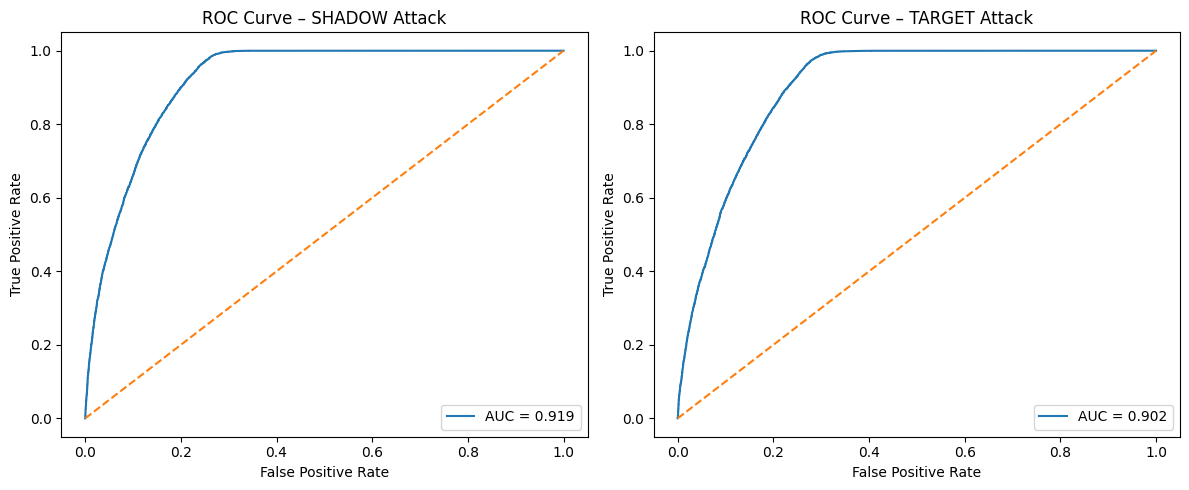

In [23]:
### Plot ROC curves (shadow vs target)
# ROC curves
fpr_shadow, tpr_shadow, _ = roc_curve(m_shadow_all, shadow_scores)
roc_auc_shadow = auc(fpr_shadow, tpr_shadow)

fpr_target, tpr_target, _ = roc_curve(m_target_all, target_scores)
roc_auc_target = auc(fpr_target, tpr_target)

plt.figure(figsize=(12, 5))

# Shadow ROC
plt.subplot(1, 2, 1)
plt.plot(fpr_shadow, tpr_shadow, label=f"AUC = {roc_auc_shadow:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – SHADOW Attack")
plt.legend(loc="lower right")

# Target ROC
plt.subplot(1, 2, 2)
plt.plot(fpr_target, tpr_target, label=f"AUC = {roc_auc_target:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – TARGET Attack")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()


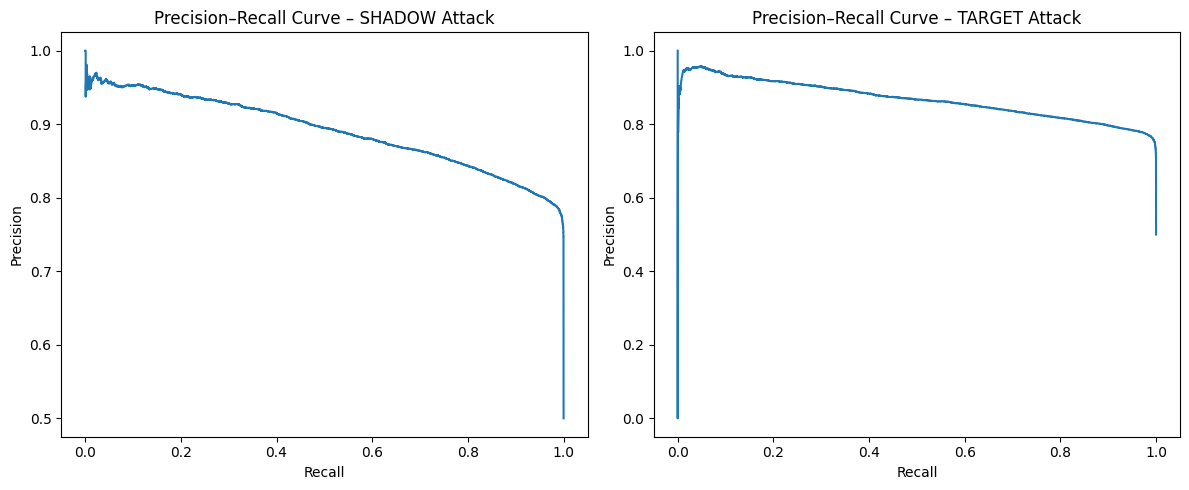

In [24]:
# Precision–Recall curves
prec_shadow, rec_shadow, _ = precision_recall_curve(m_shadow_all, shadow_scores)
prec_target, rec_target, _ = precision_recall_curve(m_target_all, target_scores)

plt.figure(figsize=(12, 5))

# Shadow PR
plt.subplot(1, 2, 1)
plt.plot(rec_shadow, prec_shadow)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – SHADOW Attack")

# Target PR
plt.subplot(1, 2, 2)
plt.plot(rec_target, prec_target)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – TARGET Attack")

plt.tight_layout()
plt.show()


##  The following cell is **optional**, if you have time, you can perform MIA on the target model without overfitting and compare the results.

##Train target model without overfitting and perform MIA on the new saved model

In [25]:
# ===============================================================
# Early-Stopping Variant of Target Training + MIA Evaluation
# ===============================================================
import copy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def train_model_with_early_stopping(
    device,
    train_set,
    test_set,
    model,
    epochs=50,
    patience=10,
    min_delta=1e-4,
    save_name="target_model_earlystop.pth"
):
    """
    Train the target model with early stopping to prevent overfitting.
    """
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
    test_loader  = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

    trainer = model_training(train_loader, test_loader, model, device)
    best_loss = float('inf')
    patience_counter = 0
    best_state = None

    train_acc_hist, test_acc_hist = [], []
    train_loss_hist, test_loss_hist = [], []

    for epoch in range(epochs):
        print(f"\n<==== EarlyStop Epoch {epoch+1}/{epochs} ====>")
        train_acc, train_loss, _ = trainer.train()
        test_acc, test_loss = trainer.test()

        train_acc_hist.append(train_acc)
        test_acc_hist.append(test_acc)
        train_loss_hist.append(train_loss)
        test_loss_hist.append(test_loss)

        print(f"Train Acc: {train_acc*100:.2f}% | Test Acc: {test_acc*100:.2f}%")
        print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

        # Early stopping check
        if test_loss < best_loss - min_delta:
            best_loss = test_loss
            best_state = copy.deepcopy(trainer.net.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f" Early stopping triggered at epoch {epoch+1}")
            break

    # Save the best model
    if best_state:
        best_path = os.path.join(MODEL_DIR, save_name)
        torch.save(best_state, best_path)
        print(f" Best model saved to: {best_path} (Val Loss: {best_loss:.4f})")
    else:
        print(" No improvement detected; using last epoch’s weights.")
        best_path = os.path.join(MODEL_DIR, save_name)
        trainer.saveModel(best_path)

    return train_acc_hist, test_acc_hist, train_loss_hist, test_loss_hist, best_path


# ---- Run Early-Stopped Training ----
early_train_acc, early_test_acc, early_train_loss, early_test_loss, early_model_path = train_model_with_early_stopping(
    device=device,
    train_set=target_train,
    test_set=target_test,
    model=resnet18(num_classes=10),
    epochs=50,
    patience=10
)



<==== EarlyStop Epoch 1/50 ====>
Train Acc: 37.63% | Test Acc: 47.04%
Train Loss: 1.7315 | Test Loss: 1.4628

<==== EarlyStop Epoch 2/50 ====>
Train Acc: 54.25% | Test Acc: 50.85%
Train Loss: 1.2804 | Test Loss: 1.4037

<==== EarlyStop Epoch 3/50 ====>
Train Acc: 63.56% | Test Acc: 53.95%
Train Loss: 1.0321 | Test Loss: 1.3864

<==== EarlyStop Epoch 4/50 ====>
Train Acc: 71.50% | Test Acc: 59.53%
Train Loss: 0.8108 | Test Loss: 1.2421

<==== EarlyStop Epoch 5/50 ====>
Train Acc: 78.45% | Test Acc: 59.81%
Train Loss: 0.6113 | Test Loss: 1.3109

<==== EarlyStop Epoch 6/50 ====>
Train Acc: 85.15% | Test Acc: 58.78%
Train Loss: 0.4308 | Test Loss: 1.4653

<==== EarlyStop Epoch 7/50 ====>
Train Acc: 87.87% | Test Acc: 59.53%
Train Loss: 0.3438 | Test Loss: 1.5009

<==== EarlyStop Epoch 8/50 ====>
Train Acc: 91.51% | Test Acc: 62.06%
Train Loss: 0.2428 | Test Loss: 1.5447

<==== EarlyStop Epoch 9/50 ====>
Train Acc: 94.53% | Test Acc: 61.57%
Train Loss: 0.1608 | Test Loss: 1.6661

<==== Ear

In [26]:
def evaluate_mia_on_target_model(
    attack_model,
    target_weights_path,
    target_train,
    target_test,
    num_classes=10,
    device=None
):
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support

    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # ---- Load TARGET model ----
    target_model = resnet18(num_classes=num_classes)
    target_model.load_state_dict(torch.load(target_weights_path, map_location="cpu"))
    target_model.eval()

    # ---- Build attack input features from TARGET model ----
    x_train_pred, y_train_true = get_prediction_vectors_and_labels(
        target_model, target_train, device=device
    )
    x_test_pred,  y_test_true  = get_prediction_vectors_and_labels(
        target_model, target_test, device=device
    )

    # membership labels
    m_train = np.ones_like(y_train_true)
    m_test  = np.zeros_like(y_test_true)

    X = np.concatenate([x_train_pred, x_test_pred], axis=0)
    Y = np.concatenate([y_train_true, y_test_true], axis=0)
    M = np.concatenate([m_train, m_test], axis=0)

    # ---- Run attack ----
    mia_scores = attack_model.infer(
        X,
        onehot(Y, num_classes),
        probabilities=True
    )
    mia_pred = (mia_scores >= 0.5).astype(int)

    # ---- Metrics ----
    acc = accuracy_score(M, mia_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(M, mia_pred, average="binary")

    print("\n### MIA on EARLY-STOPPED TARGET MODEL ###")
    print(f"acc={acc:.3f}")
    print(f"precision={precision:.3f}")
    print(f"recall={recall:.3f}")
    print(f"f1={f1:.3f}")

    return {
        "scores": mia_scores,
        "true": M,
        "acc": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }


In [27]:
earlystop_path = os.path.join(MODEL_DIR, "target_model_earlystop.pth")

early_results = evaluate_mia_on_target_model(
    attack_model=attack_model,       #trained SHADOW-based MIA model
    target_weights_path=earlystop_path,
    target_train=target_train,
    target_test=target_test,
    num_classes=10,
    device=device
)



### MIA on EARLY-STOPPED TARGET MODEL ###
acc=0.504
precision=0.572
recall=0.031
f1=0.059


In [28]:
orig_target_path = os.path.join(MODEL_DIR, "target_model.pth")

orig_mia_results = evaluate_mia_on_target_model(
    attack_model=attack_model,
    target_weights_path=orig_target_path,
    target_train=target_train,
    target_test=target_test,
    num_classes=10,
    device=device
)



### MIA on EARLY-STOPPED TARGET MODEL ###
acc=0.843
precision=0.787
recall=0.940
f1=0.856


In [29]:
def save_attack_model(attack_model, save_dir, filename="mia_attack_model.pth"):
    """
    Saves the ART MembershipInferenceBlackBox attack model's NN to disk.
    """
    os.makedirs(save_dir, exist_ok=True)

    save_path = os.path.join(save_dir, filename)

    # The attack model stored inside ART object:
    # attack_model.attack_model  <-- this is the actual PyTorch NN
    torch.save(attack_model.attack_model.state_dict(), save_path)

    print(f"Attack model saved to: {save_path}")
    return save_path


In [30]:
attack_model_path = save_attack_model(
    attack_model,
    save_dir=MODEL_DIR,
    filename="mia_attack_model.pth"
)


Attack model saved to: /content/drive/MyDrive/ML_Privacy_Lab/saved_models/mia_attack_model.pth
